**Imports and Bicubic Kernel Definition**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
image_files = ['img1.png', 'img2.tif', 'img3.tif']
scale_factor = 2

In [3]:
def bicubic_kernel(x, a=-0.5):
    """Standard Catmull-Rom Cubic Spline Kernel."""
    x = abs(x)
    if x <= 1:
        return (a + 2) * (x**3) - (a + 3) * (x**2) + 1
    elif 1 < x < 2:
        return a * (x**3) - 5 * a * (x**2) + 8 * a * x - 4 * a
    return 0

**Bicubic Implementation with Padding**

In [4]:
def bicubic_scratch(img, scale):
    h, w = img.shape[:2]
    new_h, new_w = int(h * scale), int(w * scale)
    
    # PADDING: Essential for 4x4 neighborhood logic at edges
    # We pad by 2 pixels on all sides
    padded = np.pad(img, ((2, 2), (2, 2)), mode='edge')
    output = np.zeros((new_h, new_w), dtype=np.uint8)

    row_ratio = h / new_h
    col_ratio = w / new_w

    for r in range(new_h):
        for c in range(new_w):
            # Source float coordinates
            src_r = r * row_ratio
            src_c = c * col_ratio
            
            # Floor coordinates
            r_int = int(np.floor(src_r))
            c_int = int(np.floor(src_c))
            
            # Fractional parts
            dr = src_r - r_int
            dc = src_c - c_int
            
            pixel_val = 0
            # 4x4 Neighborhood Loop
            for i in range(-1, 3):
                for j in range(-1, 3):
                    # Weight calculation using the kernel
                    weight = bicubic_kernel(i - dr) * bicubic_kernel(j - dc)
                    # Accessing padded image (index + 2 shift)
                    pixel_val += padded[r_int + i + 2, c_int + j + 2] * weight
            
            output[r, c] = np.clip(pixel_val, 0, 255)
            
    return output

**Verification vs cv2.INTER_CUBIC**

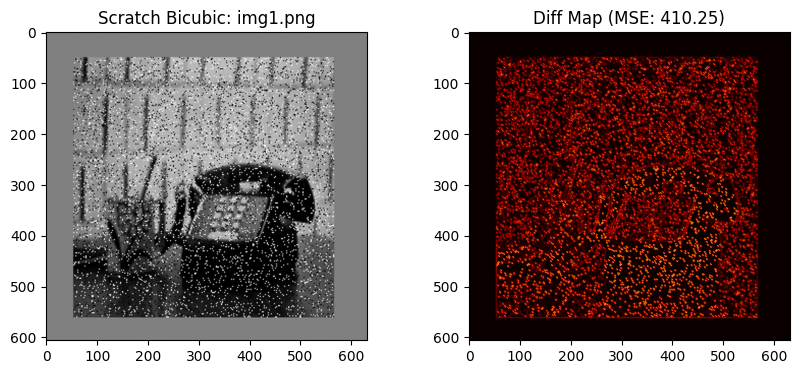

File: img1.png | Time: 47.4033s | MSE: 410.2513


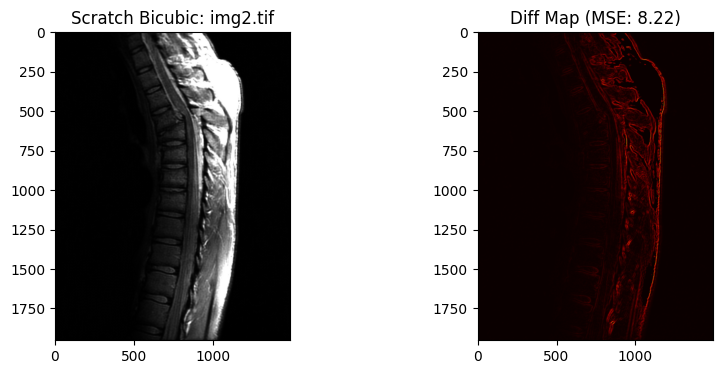

File: img2.tif | Time: 368.4720s | MSE: 8.2235


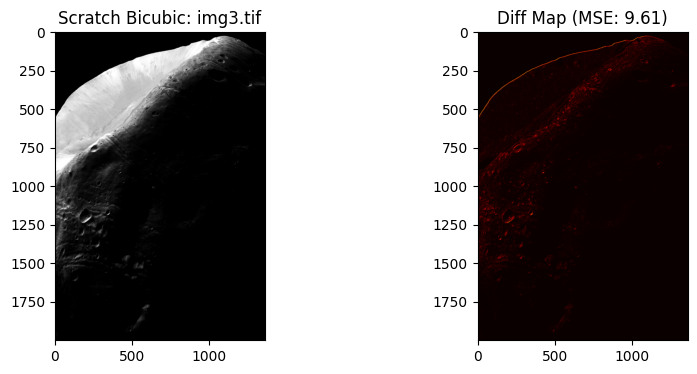

File: img3.tif | Time: 416.8076s | MSE: 9.6072


In [5]:
for file in image_files:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    
    start = time.time()
    res_scratch = bicubic_scratch(img, scale_factor)
    duration = time.time() - start
    
    res_cv2 = cv2.resize(img, (img.shape[1]*scale_factor, img.shape[0]*scale_factor), 
                         interpolation=cv2.INTER_CUBIC)
    
    mse = np.mean((res_scratch.astype(float) - res_cv2.astype(float))**2)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(res_scratch, cmap='gray'); plt.title(f'Scratch Bicubic: {file}')
    plt.subplot(1, 2, 2); plt.imshow(np.abs(res_scratch.astype(int) - res_cv2.astype(int)), cmap='hot')
    plt.title(f'Diff Map (MSE: {mse:.2f})')
    plt.show()
    
    print(f"File: {file} | Time: {duration:.4f}s | MSE: {mse:.4f}")